# Base Model QED
This is the base setup for working on QED data.
It shows how to import the data and how to convert the expressions into different formats.

amplitdues: prefix  
squared amplitdues: hybrid prefix

In [1]:
colab = False

if colab:
    # Install the most re version of TensorFlow to use the improved
    # masking support for `tf.keras.layers.MultiHeadAttention`.
    !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
    !pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
    !pip install -q tensorflow_datasets
    !pip install -q -U tensorflow-text tensorflow
    !pip install -q icecream

In [2]:
import os
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SYMBA/models')

In [3]:
from icecream import ic
import sympy as sp
from itertools import (takewhile,repeat)
from tqdm import tqdm
import numpy as np
import sys
import os
import importlib.util
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
import pickle
import tensorflow_text as tf_text

2022-12-01 15:40:52.054966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 15:40:52.228170: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-01 15:40:52.295970: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 15:40:52.969483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [4]:
tf.config.list_physical_devices('GPU')

2022-12-01 15:40:54.244572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 15:40:54.279567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 15:40:54.279757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [6]:
import data_preprocessing.tree.sympy_to_tree as sp2tree
from data_preprocessing.sympy_prefix.source.SympyPrefix import prefix_to_sympy, sympy_to_prefix, sympy_to_hybrid_prefix, hybrid_prefix_to_sympy
from data_preprocessing.ampl_tree.source.ampl_to_tree import ampl_to_tree, raw_ampl_to_tree, expand_tree, contract_tree, subscripts_to_subtree, rename_indices, get_tree, tree_to_prefix

In [7]:
import data_preprocessing.expressions_shortener.expressions_shortener as es

# Data Preparation
This only needs to be run once, then the data is cached.

In [5]:
import re
def fix_i(expr_str):
    reg_ex = "[^a-z]i[^a-z,^\d]"
    replaced = re.sub(reg_ex, fix_i_match, expr_str)
    return replaced
    
def fix_i_match(matchobj):
    """
    i --> I
    """
    match = matchobj.group(0)
    return match.replace("i", "I")


def rawincount(filename):
    """count numer of lines in a file. 
    From https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python
    """
    f = open(filename, 'rb')
    bufgen = takewhile(lambda x: x, (f.raw.read(1024*1024) for _ in repeat(None)))
    return sum( buf.count(b'\n') for buf in bufgen )

def load_raw_amplitudes(filename, max_lines=-1):
    """
    Loading raw amplitudes from filename.
    
    Options:
        - `max_lines`: maximum number of lines to read
    """
    print("Loading amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
        ic(number_of_lines)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines)
    with open(filename) as f:
        line = f.readline()
        ctr = 0
        data[ctr] = line.replace("\n", "").split(";")
        while line:
            line = f.readline()
            if line != "":
                data[ctr] = line.replace("\n", "").split(";")
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data


def load_squared_amplitudes(filename, max_lines=-1):
    """
    Loading squared amplitudes from filename and parsing into sympy.
    All squared amplitudes should be exportet from sympy and thus be readable
    without any preprocessing.

    Options:
        - `max_lines`: maximum number of lines to read

    Returns:
        list of squared amplitudes, each as a sympy expression
    """
    print("Loading squared amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
        ic(number_of_lines)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines)
    with open(filename) as f:
       line = f.readline()
       line_sp = sp.sympify(line.strip())
       ctr = 0
       data[ctr] = line_sp
       while line:
            line = f.readline()
            if line != "":
                line = line.strip()
                line = fix_i(line)
                line_sp = sp.sympify(line.strip())
                data[ctr] = line_sp
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data

In [ ]:
data_folder = "../data.nosync/"
amplitudes_filename_start = "QED_amplitudes_TreeLevel_"
sqamplitudes_filename_start = "QED_sqamplitudes_TreeLevel_"
processes = ["1to2", "2to1", "2to2", "2to3", "3to2"]
max_lines = -1

amplitudes = []
sqamplitudes = []
for process in processes:
    ampl_f = data_folder + amplitudes_filename_start + process + "_raw"+ ".txt"
    sqampl_f = data_folder + sqamplitudes_filename_start + process + ".txt"
    amplitudes_process = load_raw_amplitudes(ampl_f, max_lines=max_lines)
    sqamplitudes_process = load_squared_amplitudes(sqampl_f, max_lines=max_lines)
    amplitudes.append(amplitudes_process)
    sqamplitudes.append(sqamplitudes_process)

We will keep the different amplitudes separated for now, so `amplitudes` has the form
`[multiplicity, i]` where `multiplicity = ["1to2", "2to1", ...]`.

In [12]:
print(amplitudes[1][-1])

['Prod', '(', '2/3', 'i', 'e', 'gamma_{%\\lambda_169,%eta_137,%del_161}', 'A_{l_3,+%\\lambda_169}(p_3)', 'c_{i_3,%eta_137}(p_1)_u^(*)', 'c_{k_3,%del_161}(p_2)_u', ')']


In [13]:
print(sqamplitudes[1][-1])

-8*e**2*(2*m_c**2 - s_12)/9


In [17]:
for a, sqa in zip(amplitudes, sqamplitudes):
    assert len(a) == len(sqa)

In [18]:
# the amplitudes are in prefix format
for a, sqa in zip(amplitudes, sqamplitudes):
    ic(len(a))
    ic(len(sqa))

ic| len(a): 431
ic| len(sqa): 431
ic| len(a): 431
ic| len(sqa): 431
ic| len(a): 10943
ic| len(sqa): 10943
ic| len(a): 129023
ic| len(sqa): 129023
ic| len(a): 129023
ic| len(sqa): 129023


## Only unique amplitudes
We only want unique amplitudes, others are thrown away.

In [19]:
def get_unique_indices(amps):
    amps = [" ".join(a) for a in amps]
    tmp = np.sort(np.unique(amps, return_index=True, axis=0)[1])
    return tmp

In [20]:
unique_indices = [get_unique_indices(a) for a in amplitudes]

In [21]:
amplitudes_unique_a = [[amplitudes[j][ind] for ind in unique_indices[j]] for j in range(len(amplitudes))]
sqamplitudes_corresponding_a = [[sqamplitudes[j][ind] for ind in unique_indices[j]] for j in range(len(amplitudes))]

In [22]:
export_folder = "../data.nosync/BaseModelDataCache/"

with open(export_folder+"amplitudes.pickle", "bw") as f:
    pickle.dump(amplitudes_unique_a, f)

with open(export_folder+"sqamplitudes.pickle", "bw") as f:
    pickle.dump(sqamplitudes_corresponding_a, f)

# Data Format Conversion
We need to convert the squared amplitudes, which are sympy expressions now, into something. In this notebook we will use the prefix notation.

In [8]:
export_folder = "../data.nosync/BaseModelDataCache/"

with open(export_folder+"amplitudes.pickle", "rb") as f:
    amplitudes_unique = pickle.load(f)
    # amplitudes_unique = [[a.split(",") for a in amps] for amps in amplitudes_unique]

with open(export_folder+"sqamplitudes.pickle", "rb") as f:
    sqamplitudes_corresponding = pickle.load(f)

In [20]:
# shorten expressions with expressions_shortener
# convert squared ampmlitudes to prefix
ctr = 0
def try_sympy_to_hybrid_prefix(expr):
    global ctr
    ctr = ctr + 1
    try:
        return sympy_to_hybrid_prefix(expr)
    except:
        print("problem with:", expr, "at ctr =", ctr)
        return 0
sqampl_hybrid_prefix = [[try_sympy_to_hybrid_prefix(a) for a in tqdm(sq)] for sq in sqamplitudes_corresponding]
np.array(sqampl_hybrid_prefix[0][0])

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/3878 [00:00<?, ?it/s]

  0%|          | 0/72694 [00:00<?, ?it/s]

  0%|          | 0/72612 [00:00<?, ?it/s]

array(['mul(', 's-', '4', 'pow', 'e', '2', 'add', 'mul', 's-', '1',
       's_12', 'mul', '2', 'pow', 'm_mu', '2', ')'], dtype='<U4')

In [22]:
# shorten expressions with expressions_shortener
# convert squared ampmlitudes to prefix
ctr = 0
def try_sympy_to_hybrid_prefix_short(expr):
    global ctr
    ctr = ctr + 1
    try:
        expr_shortened = es.shorten_expression(expr)
        return sympy_to_hybrid_prefix(expr_shortened)
    except:
        print("problem with:", expr, "at ctr =", ctr)
        return 0
sqampl_hybrid_prefix_short = [[try_sympy_to_hybrid_prefix_short(a) for a in tqdm(sq)] for sq in sqamplitudes_corresponding]
np.array(sqampl_hybrid_prefix[0][0])

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/3878 [00:00<?, ?it/s]

  0%|          | 0/72694 [00:00<?, ?it/s]

  0%|          | 0/72612 [00:00<?, ?it/s]

array(['mul(', 's-', '4', 'pow', 'e', '2', 'add', 'mul', 's-', '1',
       's_12', 'mul', '2', 'pow', 'm_mu', '2', ')'], dtype='<U4')

In [23]:
sqampls_lengths = [[len(a) for a in sqampls] for sqampls in sqampl_hybrid_prefix]
sqampls_lengths_short = [[len(a) for a in sqampls] for sqampls in sqampl_hybrid_prefix_short]

Text(0, 0.5, 'number of occurances')

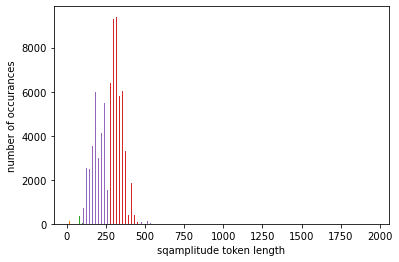

In [24]:
plt.hist(sqampls_lengths, bins=100,);
plt.xlabel("sqamplitude token length")
plt.ylabel("number of occurances")

Text(0, 0.5, 'number of occurances')

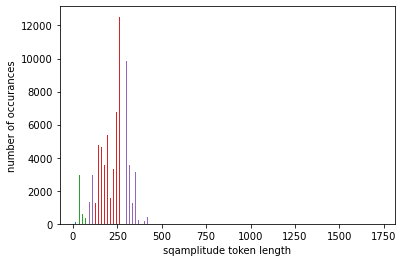

In [25]:
plt.hist(sqampls_lengths_short, bins=100,);
plt.xlabel("sqamplitude token length")
plt.ylabel("number of occurances")

In [9]:
# convert amplitudes to prefix
amplitudes_tree = [[raw_ampl_to_tree(a, needs_split=False) for a in tqdm(aa)] for aa in amplitudes_unique]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/3878 [00:00<?, ?it/s]

  0%|          | 0/72694 [00:00<?, ?it/s]

  0%|          | 0/72612 [00:00<?, ?it/s]

In [10]:
amplitudes_tree[0][0].pretty_print(unicodelines=True)
amplitudes_tree[0][-10].pretty_print(unicodelines=True)

                                                   Prod                                                 
 ┌───┬───┬─────────────────┬────────────────────────┼────────────────────┬───────────────────┐           
 │   │   │               gamma                    A^(*)                 mu_u              mu_u^(*)      
 │   │   │       ┌─────────┼────────┐      ┌────────┼────────┐    ┌──────┼───────┐    ┌──────┼───────┐   
 -1  i   e  %lambda_167 %eta_137 %gam_155 %l_3 %lambda_167 (p_3) %i_3 %gam_155 (p_1) %k_3 %eta_137 (p_2)

                                               Prod                                                
 ┌────┬───┬──────────────┬──────────────────────┼───────────────────┬───────────────────┐           
 │    │   │            gamma                  A^(*)                b_u               b_u^(*)       
 │    │   │     ┌────────┼────────┐      ┌──────┼───────┐    ┌──────┼───────┐    ┌──────┼───────┐   
-1/3  i   e  %tau_111 %del_171 %del_172 %l_3 %tau_111 (p_3) %i_3 %del_

In [11]:
amplitudes_hybrid_prefix = [[tree_to_prefix(t, hybrid=True) for t in tqdm(tt)] for tt in amplitudes_tree]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/3878 [00:00<?, ?it/s]

  0%|          | 0/72694 [00:00<?, ?it/s]

  0%|          | 0/72612 [00:00<?, ?it/s]

In [14]:
amplitudes_hybrid_prefix[0][0]

['Prod(',
 '-1',
 'i',
 'e',
 'gamma',
 '%lambda_167',
 '%eta_137',
 '%gam_155',
 'A^(*)',
 '%l_3',
 '%lambda_167',
 '(p_3)',
 'mu_u',
 '%i_3',
 '%gam_155',
 '(p_1)',
 'mu_u^(*)',
 '%k_3',
 '%eta_137',
 '(p_2)',
 ')']

In [15]:
with open(export_folder+"amplitudes_hybrid_prefix.pickle", "bw") as f:
    pickle.dump(amplitudes_hybrid_prefix, f)
# with open(export_folder+"sqampl_hybrid_prefix_short.pickle", "bw") as f:
#     pickle.dump(sqampl_hybrid_prefix_short, f)

# Reloading converted amplitudes and squared amplitudes

In [16]:
export_folder = "../data.nosync/BaseModelDataCache/"

with open(export_folder+"amplitudes_hybrid_prefix.pickle", "br") as f:
    amplitudes_hybrid_prefix = pickle.load(f)
with open(export_folder+"sqampl_hybrid_prefix_short.pickle", "br") as f:
    sqampl_hybrid_prefix_short = pickle.load(f)

In [17]:
print(amplitudes_hybrid_prefix[0][0])
print(amplitudes_hybrid_prefix[0][-10])

['Prod(', '-1', 'i', 'e', 'gamma', '%lambda_167', '%eta_137', '%gam_155', 'A^(*)', '%l_3', '%lambda_167', '(p_3)', 'mu_u', '%i_3', '%gam_155', '(p_1)', 'mu_u^(*)', '%k_3', '%eta_137', '(p_2)', ')']
['Prod(', '-1/3', 'i', 'e', 'gamma', '%tau_111', '%del_171', '%del_172', 'A^(*)', '%l_3', '%tau_111', '(p_3)', 'b_u', '%i_3', '%del_172', '(p_1)', 'b_u^(*)', '%k_3', '%del_171', '(p_2)', ')']


In [18]:
print(sqampl_hybrid_prefix_short[0][0])
print(sqampl_hybrid_prefix_short[0][-10])

['mul(', 's-', '4', 'pow', 'e', '2', 'add', 'mul', 's-', '1', 's_12', 'mul', '2', 'm2mu', ')']
['mul(', 'mul', 's-', '4', 'pow', '9', 's-', '1', 'pow', 'e', '2', 'add', 'mul', 's-', '1', 's_12', 'mul', '2', 'm2b', ')']


In [19]:
ampls_lengths = [[len(a) for a in ampls] for ampls in amplitudes_hybrid_prefix]
sqampls_lengths_short = [[len(a) for a in sqampls] for sqampls in sqampl_hybrid_prefix_short]

Text(0, 0.5, 'number of occurances')

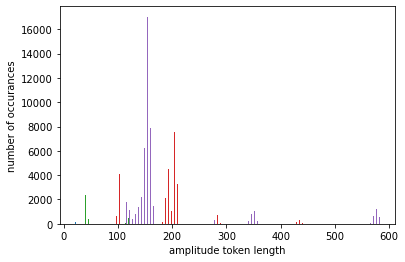

In [20]:
plt.hist(ampls_lengths, bins=100,);
plt.xlabel("amplitude token length")
plt.ylabel("number of occurances")

Text(0, 0.5, 'number of occurances')

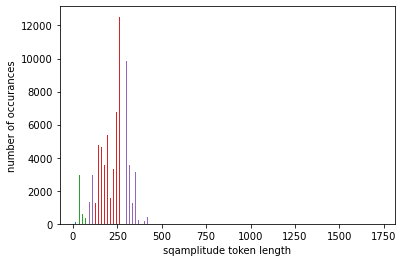

In [21]:
plt.hist(sqampls_lengths_short, bins=100,);
plt.xlabel("sqamplitude token length")
plt.ylabel("number of occurances")

Say we have a maximal sequence length of 350.
Let's do a train-test split and then filter out the too long amplitudes

In [24]:
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(len(amplitudes_hybrid_prefix)):
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(amplitudes_hybrid_prefix[i], sqampl_hybrid_prefix_short[i],
        test_size=0.1, random_state=42)
    X_train.append(X_train_tmp)
    y_train.append(y_train_tmp)
    X_test.append(X_test_tmp)
    y_test.append(y_test_tmp)

In [25]:
with open(export_folder+"X_train_a_hprefix_sqa_hprefix.pickle", "bw") as f:
    pickle.dump(X_train, f)
with open(export_folder+"y_train_a_hprefix_sqa_hprefix.pickle", "bw") as f:
    pickle.dump(y_train, f)
with open(export_folder+"X_test_a_hprefix_sqa_hprefix.pickle", "bw") as f:
    pickle.dump(X_test, f)
with open(export_folder+"y_test_a_hprefix_sqa_hprefix.pickle", "bw") as f:
    pickle.dump(y_test, f)

In [26]:
export_folder = "../data.nosync/BaseModelDataCache/"

with open(export_folder+"X_train_a_hprefix_sqa_hprefix.pickle", "br") as f:
    X_train = pickle.load(f)
with open(export_folder+"y_train_a_hprefix_sqa_hprefix.pickle", "br") as f:
    y_train = pickle.load(f)
with open(export_folder+"X_test_a_hprefix_sqa_hprefix.pickle", "br") as f:
    X_test = pickle.load(f)
with open(export_folder+"y_test_a_hprefix_sqa_hprefix.pickle", "br") as f:
    y_test = pickle.load(f)

Only use those X,y where both are at most `sequence_length` long.

In [27]:
def remove_too_long(X, y, idxs_okay_export, max_seq_len=350, idxs_okay=None):
    """
    find indices where X and y are less than `max_seq_len` long.
    Append to `idxs_okay_export`.
    """
    if idxs_okay is None:
        X_idxs_ok = np.where([len(x) < max_seq_len for x in X])[0]
        y_idxs_ok = np.where([len(y) < max_seq_len for y in y])[0]
        idxs_okay = np.intersect1d(X_idxs_ok, y_idxs_ok) 
    idxs_okay_export.append(idxs_okay)
    X_new = [X[i] for i in idxs_okay]
    y_new = [y[i] for i in idxs_okay]
    return X_new, y_new

In [28]:
vocab_size = 500
max_seq_len = 350
batch_size = 1

idxs_train_okay_export = []
X_train_filtered, y_train_filtered = [], []
for i in range(len(X_train)):
    X_train_filtered_tmp, y_train_filtered_tmp = remove_too_long(
        X_train[i], y_train[i], idxs_train_okay_export, max_seq_len=max_seq_len)
    X_train_filtered.append(X_train_filtered_tmp)
    y_train_filtered.append(y_train_filtered_tmp)

idxs_test_okay_export = []
X_test_filtered, y_test_filtered = [], []
for i in range(len(X_test)):
    X_test_filtered_tmp, y_test_filtered_tmp = remove_too_long(
        X_test[i], y_test[i], idxs_test_okay_export, max_seq_len=max_seq_len)
    X_test_filtered.append(X_test_filtered_tmp)
    y_test_filtered.append(y_test_filtered_tmp)

In [29]:
# percentage of amplitudes kept depending on process (1to1, 1to2, ...)
np.array([len(idx) for idx in idxs_train_okay_export]) / np.array([len(idx) for idx in X_train]) 

array([1.        , 1.        , 1.        , 0.93889093, 0.93845448])

In [30]:
# percentage of all amplitudes that are kept (not too long)
np.sum([len(idx) for idx in idxs_train_okay_export]) / np.sum([len(idx) for idx in X_train]) 

0.9403531214208154

In [31]:
for i in range(len(X_train_filtered)):
    assert len(X_train_filtered[i]) == len(y_train_filtered[i])

for i in range(len(X_test_filtered)):
    assert len(X_test_filtered[i]) == len(y_test_filtered[i])

In [32]:
X_train_final = [[" ".join(x) for x in X] for X in X_train_filtered]
y_train_final = [[" ".join(yy) for yy in y] for y in y_train_filtered]

X_test_final = [[" ".join(x) for x in X] for X in X_test_filtered]
y_test_final = [[" ".join(yy) for yy in y] for y in y_test_filtered]

In [33]:
print(X_train[1][12])

['Prod(', '-1', 'i', 'e', 'gamma', '%lambda_167', '%eta_137', '%del_155', 'A', '%l_3', '%lambda_167', '(p_3)', 'mu_u^(*)', '%i_3', '%eta_137', '(p_1)', 'mu_u', '%k_3', '%del_155', '(p_2)', ')']


In [34]:
print(y_train[1][12])

['mul(', 's-', '2', 'pow', 'e', '2', 'add', 'mul', 's-', '1', 's_12', 'mul', '2', 'm2mu', ')']


# Final Dataset, Data Pipeline 

In [35]:
export_folder = "../data.nosync/BaseModelDataCache/"

vocab_size = 500
max_seq_len = 350
batch_size = 1


# reading to sympy takes quite long.
# We're here caching the alreaday converted amplitudes
X_train_cache_file = export_folder+"X_train_final_Xhp_yhp.pickle"
y_train_cache_file = export_folder+"y_train_final_Xhp_yhp.pickle"
X_test_cache_file = export_folder+"X_test_final_Xhp_yhp.pickle"
y_test_cache_file = export_folder+"y_test_final_Xhp_yhp.pickle"

if os.path.exists(X_train_cache_file) & os.path.exists(y_train_cache_file):
    print("Exists, loading")
    with open(X_train_cache_file, "rb") as f:
        X_train_final = pickle.load(f)
    with open(y_train_cache_file, "rb") as f:
        y_train_final = pickle.load(f)

else:
    with open(X_train_cache_file, "wb") as f:
        pickle.dump(X_train_final, f)
    with open(y_train_cache_file, "wb") as f:
        pickle.dump(y_train_final, f)

if os.path.exists(X_test_cache_file) & os.path.exists(y_test_cache_file):
    print("Exists, loading")
    with open(X_test_cache_file, "rb") as f:
        X_test_final = pickle.load(f)
    with open(y_test_cache_file, "rb") as f:
        y_test_final = pickle.load(f)

else:
    with open(X_test_cache_file, "wb") as f:
        pickle.dump(X_test_final, f)
    with open(y_test_cache_file, "wb") as f:
        pickle.dump(y_test_final, f)

In [36]:
X_train_final[0][0]

'Prod( -1/3 i e gamma %nu_92 %gam_161 %del_167 A %l_3 %nu_92 (p_3) d_u^(*) %i_3 %gam_161 (p_1) d_v %k_3 %del_167 (p_2) )'

In [37]:
y_train_final[0][0]

'mul( mul 4 pow 9 s- 1 pow e 2 add s_12 mul 2 m2d )'

In [38]:
def flatten(l):
    return [item for sublist in l for item in sublist]

X_train_all = flatten(X_train_final)
y_train_all = flatten(y_train_final) 

X_test_all = flatten(X_test_final)
y_test_all = flatten(y_test_final) 

In [39]:
def train_test_split(ds, ds_size, train_split=0.9, shuffle=True, shuffle_size=10000):
    assert (train_split>=0) & (train_split<=1)
    # test_split = 1 - train_split
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size)
    
    return train_ds, test_ds

In [40]:
df_train = tf.data.Dataset.from_tensor_slices((X_train_all, y_train_all)).prefetch(2)
df_test = tf.data.Dataset.from_tensor_slices((X_test_all, y_test_all)).prefetch(2)

2022-12-01 17:29:34.696898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 17:29:34.698403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 17:29:34.698595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 17:29:34.698672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [41]:
df_train, df_val = train_test_split(df_train, df_train.cardinality().numpy(), train_split=0.98)

In [42]:
ic(df_val.cardinality().numpy())
ic(df_train.cardinality().numpy())
1 - df_val.cardinality() / df_train.cardinality()

ic| df_val.cardinality().numpy(): 2529
ic| df_train.cardinality().numpy(): 123909


<tf.Tensor: shape=(), dtype=float64, numpy=0.9795898603007045>

In [43]:
for x_examples, y_examples in df_train.batch(3).take(1):
    print("amplitudes:")
    for xx in x_examples.numpy():
        print(xx)
    print("squared amplitudes:")
    for yy in y_examples.numpy():
        print(yy)

amplitudes:
b'Prod( 1/27 i Pow e 3 Pow Sum( s_11 Prod 2 s_13 Prod -2 s_14 Prod -2 s_34 s_44 reg_prop ) -1 Pow Sum( Pow m_s 2 Prod 2 s_34 Prod -1 s_44 Prod -1 reg_prop ) -1 gamma %lambda_184 %eta_211 %eps_41 gamma %tau_161 %del_216 %eta_212 Sum( Prod m_s gamma %tau_161 %eta_210 %eta_211 Prod( p_1 %tau_164 gamma %tau_161 %eta_210 %eta_273 gamma %tau_164 %eta_273 %eta_211 ) Prod( p_2 %tau_164 gamma %tau_161 %eta_210 %eta_274 gamma %tau_164 %eta_274 %eta_211 ) Prod( -1 p_5 %tau_164 gamma %tau_161 %eta_210 %eta_275 gamma %tau_164 %eta_275 %eta_211 ) ) A^(*) %i_5 %lambda_184 (p_3) b_u^(*) %k_3 %del_216 (p_2) b_u %l_5 %eta_212 (p_5) s_u^(*) %i_3 %eta_210 (p_1) s_u %k_5 %eps_41 (p_4) )'
b'Prod( 8/27 i Pow e 3 Pow Sum( Pow m_s 2 Prod 2 s_34 s_44 reg_prop ) -1 Pow Sum( Pow m_s 2 Prod -2 s_13 Prod -2 s_14 Prod 2 s_34 s_44 reg_prop ) -1 Sum( Prod( p_1 %lambda_388 gamma %lambda_386 %eta_650 %eta_651 gamma %lambda_388 %eta_652 %eps_136 A %k_3 %lambda_386 (p_2) c_v^(*) %i_3 %eta_650 (p_1) c_v %l_5 %e

In [44]:
class BogoTokenizer(tf_text.Tokenizer, tf_text.Detokenizer):
    """
    My implementation of a tf_text.Tokenizer.
    It's actually just a wrapper around TextVectorization,
    but so that it works for my case.
    """
    def __init__(self, max_tokens=vocab_size, output_mode="int", output_sequence_length=None,
            standardize=None, ragged=False,):
        super(BogoTokenizer, self).__init__()
        self.vectorizer = TextVectorization(max_tokens=max_tokens, output_mode=output_mode,
            output_sequence_length=output_sequence_length, ragged=ragged, standardize=None)
        self.start = "[START]"
        self.end = "[END]"

    def tokenize(self, input):
        input_with_start_end = [self.start+" "+inp+" "+self.end for inp in input]
        return self.vectorizer(input_with_start_end)

    def encode(self, input):
        return self.vectorizer(input)

    def adapt(self, input):
        input_with_start_end = [self.start+" "+inp+" "+self.end for inp in input]
        self.vectorizer.adapt(input_with_start_end)

    def detokenize(self, tokens):
        vocab = tf.constant(self.vectorizer.get_vocabulary())
        sentences = tf.gather(vocab, tokens)
        sentences = sentences[:, 1:-1]
        signature = tf.type_spec_from_value(tf.strings.join(sentences[0]))
        sentences = tf.map_fn(fn=lambda s: tf.strings.join(s, separator=" "), elems=sentences,
            fn_output_signature=signature)
        return sentences

    def lookup(self, tokens):
        vocab = tf.constant(self.vectorizer.get_vocabulary())
        return tf.gather(vocab, tokens)

    def get_vocabulary(self):
        return self.vectorizer.get_vocabulary()

    def get_vocab_size(self):
        return len(self.vectorizer.get_vocabulary())

bogoTokenizer = BogoTokenizer(output_sequence_length=None, ragged=True)
bogoTokenizer.adapt(["hello world", "this is a test"])
tokens = ic(bogoTokenizer.tokenize(["hello world", "this is a test"]))
print("lookup")
print(bogoTokenizer.lookup(tokens))
print("detokenize")
print(bogoTokenizer.detokenize(tokens))

ic| bogoTokenizer.tokenize(["hello world", "this is a test"]): <tf.RaggedTensor [[2, 8, 4, 3], [2, 5, 7, 9, 6, 3]]>


lookup
<tf.RaggedTensor [[b'[START]', b'hello', b'world', b'[END]'],
 [b'[START]', b'this', b'is', b'a', b'test', b'[END]']]>
detokenize
tf.Tensor([b'hello world' b'this is a test'], shape=(2,), dtype=string)


In [45]:
X_train_all[0]

'Prod( -1/3 i e gamma %nu_92 %gam_161 %del_167 A %l_3 %nu_92 (p_3) d_u^(*) %i_3 %gam_161 (p_1) d_v %k_3 %del_167 (p_2) )'

In [46]:
tokenizer_X = BogoTokenizer(ragged=True)
tokenizer_y = BogoTokenizer(ragged=True)

tokenizer_X.adapt(X_train_all)
tokenizer_y.adapt(y_train_all)

tokenizers = {"X": tokenizer_X, "y": tokenizer_y}

In [47]:
enc = tokenizer_X.tokenize(["banana Prod gamma banananana"])
print(enc)
round_trip = tokenizer_X.detokenize(enc)
print(round_trip)

<tf.RaggedTensor [[28, 1, 4, 2, 1, 29]]>
tf.Tensor([b'[UNK] Prod gamma [UNK]'], shape=(1,), dtype=string)


In [48]:
tokenizer_X.detokenize([[45, 42, 1, 2, 3, 46]])

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b's_12 [UNK] gamma )'], dtype=object)>

In [49]:
tokenizer_X.lookup([[45, 42, 1, 2, 3, 46]])

<tf.Tensor: shape=(1, 6), dtype=string, numpy=
array([[b's_24', b's_12', b'[UNK]', b'gamma', b')', b'-1/2']],
      dtype=object)>

In [50]:
print(x_examples)
encoded = tokenizer_X.tokenize(x_examples)
print("encoded batch:")
for row in encoded.to_list():
    print(row)

round_trip = tokenizer_X.detokenize(encoded)
print(round_trip)

tf.Tensor(
[b'Prod( 1/27 i Pow e 3 Pow Sum( s_11 Prod 2 s_13 Prod -2 s_14 Prod -2 s_34 s_44 reg_prop ) -1 Pow Sum( Pow m_s 2 Prod 2 s_34 Prod -1 s_44 Prod -1 reg_prop ) -1 gamma %lambda_184 %eta_211 %eps_41 gamma %tau_161 %del_216 %eta_212 Sum( Prod m_s gamma %tau_161 %eta_210 %eta_211 Prod( p_1 %tau_164 gamma %tau_161 %eta_210 %eta_273 gamma %tau_164 %eta_273 %eta_211 ) Prod( p_2 %tau_164 gamma %tau_161 %eta_210 %eta_274 gamma %tau_164 %eta_274 %eta_211 ) Prod( -1 p_5 %tau_164 gamma %tau_161 %eta_210 %eta_275 gamma %tau_164 %eta_275 %eta_211 ) ) A^(*) %i_5 %lambda_184 (p_3) b_u^(*) %k_3 %del_216 (p_2) b_u %l_5 %eta_212 (p_5) s_u^(*) %i_3 %eta_210 (p_1) s_u %k_5 %eps_41 (p_4) )'
 b'Prod( 8/27 i Pow e 3 Pow Sum( Pow m_s 2 Prod 2 s_34 s_44 reg_prop ) -1 Pow Sum( Pow m_s 2 Prod -2 s_13 Prod -2 s_14 Prod 2 s_34 s_44 reg_prop ) -1 Sum( Prod( p_1 %lambda_388 gamma %lambda_386 %eta_650 %eta_651 gamma %lambda_388 %eta_652 %eps_136 A %k_3 %lambda_386 (p_2) c_v^(*) %i_3 %eta_650 (p_1) c_v %l_5 %

In [51]:
MAX_TOKENS=350
def prepare_batch(X, y):
    X = tokenizers["X"].encode(X)      # Output is ragged.
    X = X[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    X = X.to_tensor()  # Convert to 0-padded dense Tensor

    y = tokenizers["y"].encode(y)
    y = y[:, :(MAX_TOKENS+1)]
    y_inputs = y[:, :-1].to_tensor()  # Drop the [END] tokens
    y_labels = y[:, 1:].to_tensor()   # Drop the [START] tokens

    return (X, y_inputs), y_labels

In [52]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [53]:
train_batches = make_batches(df_train)
val_batches = make_batches(df_val)
test_batches = make_batches(df_test)

In [54]:
train_batches

<PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [55]:
for (xx, yy), yy_labels in train_batches.take(1):
    print(xx.shape)
    print(yy.shape)
    print(yy_labels.shape)

(32, 281)
(32, 345)
(32, 345)


In [56]:
print(xx[0][:10])
print(yy[0][:10])
print(yy_labels[0][:10])

tf.Tensor([ 7 26  5 27 30  5 16 37  4 23], shape=(10,), dtype=int64)
tf.Tensor([ 3 51 13 29 28 13 16 25 22 19], shape=(10,), dtype=int64)
tf.Tensor([51 13 29 28 13 16 25 22 19  6], shape=(10,), dtype=int64)


In [57]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [58]:
class PositionalEmbedding(tf.keras.layers.Layer):
  """embedding + positional encoding"""
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [59]:
embed_X = PositionalEmbedding(vocab_size=tokenizers["X"].get_vocab_size(), d_model=512)
embed_y = PositionalEmbedding(vocab_size=tokenizers["y"].get_vocab_size(), d_model=512)

X_emb = embed_X(xx)
y_emb = embed_X(yy)

In [60]:
X_emb._keras_mask

<tf.Tensor: shape=(32, 281), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [61]:
xx[0][0:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 7, 26,  5, 27, 30])>

In [62]:
X_emb[0][0:5]

<tf.Tensor: shape=(5, 512), dtype=float32, numpy=
array([[-0.13546064,  0.69598347, -0.28972754, ...,  1.1727179 ,
         1.0892569 ,  0.6714809 ],
       [ 1.7553012 ,  0.77115774,  1.9187546 , ...,  0.8091723 ,
         0.01575792,  1.4015987 ],
       [ 0.5122517 ,  1.6046032 ,  1.6691855 , ...,  1.4501709 ,
         0.8326774 ,  2.0348377 ],
       [ 0.68419015,  0.61280715, -0.753955  , ...,  1.3192405 ,
         1.3271487 ,  0.04875952],
       [ 0.2567833 , -0.5721197 , -0.5291657 , ...,  0.985366  ,
         0.4667887 ,  0.9598986 ]], dtype=float32)>

In [63]:
X_emb[0][1][-2]

<tf.Tensor: shape=(), dtype=float32, numpy=0.015757918>

## Building the actual layers

In [64]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [65]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [66]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(X_emb.shape)
print(y_emb.shape)
print(sample_ca(X_emb, y_emb).shape)


(32, 281, 512)
(32, 345, 512)


2022-12-01 17:34:52.061197: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(32, 281, 512)


2022-12-01 17:34:52.626417: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


In [67]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [68]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(X_emb.shape)
print(sample_gsa(X_emb).shape)


(32, 281, 512)
(32, 281, 512)


In [69]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [70]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [71]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [72]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [73]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [74]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [75]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [76]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [77]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers["X"].get_vocab_size(),
    target_vocab_size=tokenizers["y"].get_vocab_size(),
    dropout_rate=dropout_rate)

In [78]:
print(transformer((X_emb[0][0:10], y_emb[0][0:10]), training=False).shape)

(10, 512, 230)


In [79]:
X_emb.shape

TensorShape([32, 281, 512])

In [80]:
print(tf.__version__) 

2.10.0


In [81]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2702848   
                                                                 
 decoder (Decoder)           multiple                  4779264   
                                                                 
 dense_16 (Dense)            multiple                  29670     
                                                                 
Total params: 7,511,782
Trainable params: 7,511,782
Non-trainable params: 0
_________________________________________________________________


In [82]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [83]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [84]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [85]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [86]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6),
        tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/2022-12-01-ahp-sqahp-checkpoint.h5',
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        ),
    tf.keras.callbacks.CSVLogger('csv_logs/2022-12-01-ahp-sqahp.csv', separator=",", append=False),
    tf.keras.callbacks.TensorBoard(log_dir='tensorboard_logs/2022-12-01-ahp-sqahp/'),
    tf.keras.callbacks.BackupAndRestore(
        'training_backup/2022-12-01-ahp-sqahp_backup/', save_freq="epoch", delete_checkpoint=True
    )
]

In [ ]:
transformer.fit(train_batches,
                epochs=10,
                validation_data=val_batches)

In [ ]:
os.listdir("saved_models")

['2022-11-09-Transformer_2to2.index',
 '2022-11-09-Transformer_2to2.data-00000-of-00001',
 '2022-11-14-Transformer_upto3to3_unique_augmented.index',
 '2022-11-09-Transformer_all_except_3to3.data-00000-of-00001',
 '2022-11-09-Transformer_all_except_3to3.index',
 '2022-11-14-Transformer_upto3to3_unique_augmented.data-00000-of-00001',
 'checkpoint']

In [274]:
transformer.save_weights("models/2022-12-01-ahp-sqahp_final")

In [263]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers["X"].tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers["y"].tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers["y"].detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers["y"].lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [264]:
translator = Translator(tokenizers, transformer)

In [265]:
sentence = X_test_final[0][0]
sentence

'Prod 2/3 Prod i Prod e Prod gamma alpha_2 alpha_0 alpha_1 Prod A^(*) i_2 alpha_2 (p_3) Prod tt i_0 alpha_1 (p_1)_u tt^(*) i_1 alpha_0 (p_2)_u'

In [266]:
tf.constant(sentence).shape

TensorShape([])

In [267]:
sentence2 = tf.constant(sentence)[tf.newaxis]

In [268]:
tokenizers["X"].tokenize(sentence2)

<tf.RaggedTensor [[45, 2, 133, 2, 43, 2, 44, 2, 3, 18, 20, 19, 2, 34, 10, 18, 40, 2, 90,
  12, 19, 31, 89, 11, 20, 72, 46]]>

In [269]:
tokenizers["X"].tokenize([""])

<tf.RaggedTensor [[45, 46]]>

In [270]:
translator(tf.constant(sentence))

(<tf.Tensor: shape=(), dtype=string, numpy=b'e 4 e e 4 s_23 e 4 s_23 s_23 e 4 s_23 s_23 s_23 s_23 s_23 s_23 s_23 s_23 s_23 s- 2 s_23 s_24 s- 2 s_23 pow m_tt 2 mul s- 2 pow m_tt 2 mul s- 2 pow s_23 2 mul 2 pow m_tt 2 mul 2 mul s_13 pow m_tt 2 add mul s- 1 mul s_23 pow m_tt 2 mul s- 2 mul s_24 pow m_tt 2 add mul s- 2 mul s_34 pow m_tt 2 add mul s- 2 mul s_12 pow m_tt 4 add mul s- 2 mul s_12 pow m_tt 4 add mul s- 2 mul s_12 pow m_tt 4 add mul s- 2 mul s_14 mul s_24 s_34 add mul s- 2 mul s_12 mul 2 mul s_13 mul s_23 pow m_tt 2 add mul s- 2 mul s_14 mul s_23 pow m_tt 2 add mul s- 2 mul s_24 mul s_34 pow m_tt 2 add mul 2 mul s_12 mul s_13 pow m_tt 2 add mul 4 mul s_13 mul s_24 pow m_tt 2 add mul 4 mul s_23 mul s_24 pow m_tt 2 mul s- 2 mul s_12 mul s_34 pow m_tt 2 mul s- 2 mul s_23 mul s- 2 mul s_23 mul pow m_tt 2 pow m_tt 2 mul s- 2 mul s_14 mul s_24 s_34 mul 2 mul s_13 mul s_23 pow m_tt 2 add mul s- 2 mul s_23 mul s_34 pow m_tt 2 mul 2 mul s_23 mul s_24 pow m_tt 2 add mul 4 mul s_24 mul pow

In [271]:
X_test_final[0][0]

'Prod 2/3 Prod i Prod e Prod gamma alpha_2 alpha_0 alpha_1 Prod A^(*) i_2 alpha_2 (p_3) Prod tt i_0 alpha_1 (p_1)_u tt^(*) i_1 alpha_0 (p_2)_u'